In [5]:
%load_ext jupyter_black
%matplotlib inline

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [6]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [7]:
import numpyro

numpyro.set_platform("cpu")  # cpu

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import jax.random as jr
import jax.numpy as jnp
import jax.tree_util as jtu

from jax import nn, config
from functools import partial

from pymdp.jax.agent import Agent as AIFAgent

from pybefit.inference import (
    run_svi,
    default_dict_numpyro_svi,
)

from pybefit.inference import NumpyroModel, NumpyroGuide
from pybefit.inference import (
    Normal,
    NormalPosterior,
    NormalGamma,
    NormalGammaPosterior,
    RegularisedHorseshoe,
    RegularisedHorseshoePosterior,
)
from pybefit.inference.numpyro.likelihoods import pymdp_likelihood as likelihood

from numpyro.infer import Predictive
import numpyro.distributions as dist

from pymdp.jax.task import PyMDPEnv

seed_key = jr.PRNGKey(101)
config.update("jax_default_matmul_precision", "float32")

In [9]:
""" Defining state factors """

agency_names = [
    "sP_oP",
    "sP_oN",
    "sN_oP",
    "sN_oN",
]

self_action_names = ["self_buttonnotpress", "self_buttonpress"]
other_action_names = ["other_buttonnotpress", "other_buttonpress"]

""" Defining number of state factors and states """
num_states = [len(agency_names), len(self_action_names), len(other_action_names)]
num_factors = len(num_states)

""" Defining control state factors """
choice_agency_names = ["no_changes"]
choice_self_action_names = ["self_notpressbutton", "self_pressbutton"]
choice_other_action_names = ["equal_distribution"]

""" Defining number of control states """
num_controls = [
    len(choice_agency_names),
    len(choice_self_action_names),
    len(choice_other_action_names),
]

""" Defining observational modalities """
obs_outcome_names = ["outcome_absent", "outcome_present"]
obs_choice_self_names = ["self_buttonnotpress", "self_buttonpress"]
obs_choice_other_names = ["other_buttonnotpress", "other_buttonpress"]

""" Defining number of observational modalities and observations """
num_obs = [
    len(obs_outcome_names),
    len(obs_choice_self_names),
    len(obs_choice_other_names),
]
num_modalities = len(num_obs)

batch_size = 80  # number of subjects
num_blocks = 15
num_timesteps = 24

In [10]:
num_exp_conditions = 5


def make_agency_task(p_outcome_env=1.0, p_other_action_env=0.5):
    a1 = jnp.array([1 - p_outcome_env, p_outcome_env])
    a2 = 1 - a1
    a3 = jnp.array([0.5, 0.5])
    A1 = jnp.stack([a1, a2, a1, a2, a3], -1)
    A2 = jnp.stack([a1, a2, a2, a1, a3], -1)
    A3 = jnp.stack([a2, a1, a1, a2, a3], -1)
    A4 = jnp.stack([a2, a1, a2, a1, a3], -1)
    _A = jnp.stack([A4, A3, A2, A1], -1).reshape(2, 5, 2, 2)

    a = jnp.eye(2)
    A = [
        jnp.broadcast_to(_A, (batch_size,) + _A.shape),
        jnp.broadcast_to(a, (batch_size,) + a.shape),
        jnp.broadcast_to(a, (batch_size,) + a.shape),
    ]

    B2 = jnp.stack([jnp.array([[1, 1], [0, 0]]), jnp.array([[0, 0], [1, 1]])], -1)
    B = [
        jnp.broadcast_to(
            jnp.eye(num_exp_conditions)[..., None],
            (batch_size, num_exp_conditions, num_exp_conditions, 1),
        ),
        jnp.broadcast_to(B2, (batch_size, 2, 2, 2)),
        jnp.broadcast_to(
            jnp.ones((num_states[-1], num_states[-1], 1)) / num_states[-1],
            (batch_size, num_states[-1], num_states[-1], 1),
        ),
    ]

    D = [
        jnp.ones((batch_size, 5)) / 5,
        jnp.ones((batch_size, num_states[1])) / num_states[1],
        jnp.ones((batch_size, num_states[2])) / num_states[2],
    ]

    dependencies = {"A": [[0, 1, 2], [1], [2]], "B": [[0], [1], [2]]}

    params = {"A": A, "B": B, "D": D}

    return PyMDPEnv(params, dependencies=dependencies)


agency_task = make_agency_task()
key, _key = jr.split(seed_key)
agency_task = agency_task.reset(_key)

In [11]:
keys = jr.split(key, batch_size + 1)
key = keys[-1]
actions = jnp.broadcast_to(jnp.array([0, 0, 0]), (batch_size, 3))
obs, agency_task = agency_task.step(keys[:batch_size], actions)

In [12]:
def broadcast_to_batch(xs, batch_size):
    return jtu.tree_map(lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape), xs)


def create_A(batch_size, p_outcome_mean, p_outcome_scale):
    # p_outcome_mean = jnp.broadcast_to(p_outcome_mean, (batch_size,))
    # p_outcome_scale = jnp.broadcast_to(p_outcome_scale, (batch_size,))

    # p_outcome_mean = alpha1 / (alpha1 + alpha2)
    # p_outcomes_scale = (alpha1 + alpha2)
    # alpha1 = jnp.broadcast_to(alpha1, (batch_size,))
    # alpha2 = jnp.broadcast_to(alpha2, (batch_size,))
    # p_outcome_scale = jnp.expand_dims(alpha1 + alpha2, -1)

    alpha2 = jnp.broadcast_to(p_outcome_scale * p_outcome_mean, (batch_size,))
    alpha1 = jnp.broadcast_to(
        p_outcome_scale * (1 - p_outcome_mean), (batch_size,)
    )  # p_outcomes_scale - alpha2
    p_outcome_scale = jnp.expand_dims(p_outcome_scale, -1)

    ### make components for first modality
    a1 = jnp.stack([alpha1, alpha2], -1)
    a = jnp.ones_like(a1) * p_outcome_scale / 2

    # self_notpress, other_notpress
    A1 = jnp.stack([p_outcome_scale - a1, a, a, a1], -1)

    # self_notpress, other_press
    A2 = jnp.stack([a, p_outcome_scale - a1, a1, a], -1)

    # self_press, other_notpress
    A3 = jnp.stack([a, a1, p_outcome_scale - a1, a], -1)

    # self_press, other_press
    A4 = jnp.stack([a1, a, a, p_outcome_scale - a1], -1)

    _pA = jnp.stack([A1, A2, A3, A4], -1).reshape(batch_size, 2, 4, 2, 2)
    null_pA = 1e4 * jnp.ones_like(_pA[..., :1, :])
    pA_outcome = jnp.concatenate([null_pA, _pA], -2)  # shape = (batch_size, 2, 4, 3, 2)

    ### A matrix for proprioception
    A_self_action = jnp.concatenate(
        [jnp.ones((2, 1)) / 2, jnp.eye(2)], -1
    )  # with null state shape = (2, 3)

    ### A matrix for observing other agent's actions
    tmp = jnp.broadcast_to(jnp.expand_dims(jnp.eye(2), -2), (2, 2, 2))
    A_other_action = jnp.concatenate(
        [jnp.ones((2, 1, 2)) / 2, tmp], -2
    )  # with null state shape = (2, 3, 2)

    A = [pA_outcome / pA_outcome.sum(1, keepdims=True)] + broadcast_to_batch(
        [A_self_action, A_other_action], batch_size
    )
    A_factor_list = [[0, 1, 2], [1], [1, 2]]

    ### make dirichlet prior
    pA = [pA_outcome] + [None] * len(A[1:])

    return A, A_factor_list, pA


A, A_list, pA = create_A(batch_size, 0.7, 1.0)

In [13]:
# we have added a null state for self which will make all observations uninformative
num_states = [
    4,
    3,
    2,
]


def create_C(batch_size, outcomepref):
    C1 = jnp.pad(outcomepref[..., None], ((0, 0), (1, 0)))
    C2 = jnp.zeros((batch_size, 2))
    C3 = jnp.zeros((batch_size, 2))

    return [C1, C2, C3]


def create_E(batch_size, habit_press):
    log_E = jnp.pad(habit_press[..., None], ((0, 0), (1, 0)))
    return nn.softmax(log_E, -1)


def create_D(batch_size, logits):
    D_context = nn.softmax(jnp.pad(logits, [(0, 0), (0, 1)]), -1)
    # D_context = jnp.array([0.25, 0.25, 0.25, 0.25])
    D_self_action = jnp.array([1.0, 0.0, 0.0])
    D_other_action = jnp.ones(num_states[-1]) / num_states[-1]

    return [
        D_context,
    ] + broadcast_to_batch([D_self_action, D_other_action], batch_size)


def create_B(batch_size):
    ### B matrix for context (agency)
    d = len(agency_names)
    B_context = jnp.expand_dims(jnp.eye(d), -1)

    ### B matrix for actions the self can make
    B_self_choice = jnp.stack(
        [jnp.array([[1, 1], [0, 0]]), jnp.array([[0, 0], [1, 1]])], -1
    )

    B_self_choice = jnp.pad(
        B_self_choice, ((1, 0), (0, 0), (0, 0))
    )  # with null state shape = (3, 3, 2)

    B_self_choice = jnp.concatenate([B_self_choice[:, :1, :], B_self_choice], axis=1)

    ### B matrix for actions the other can make
    d1, p1 = len(other_action_names), len(choice_other_action_names)
    B_other_choice = jnp.ones((d1, d1, p1)) / d1

    B = broadcast_to_batch([B_context, B_self_choice, B_other_choice], batch_size)
    dependencies = [[0], [1], [2]]

    return B, dependencies

In [14]:
def auxiliary_likelihood(z, agent, data, input, *args):
    batch_size = agent.batch_size
    assert batch_size == len(z)

    scale_self = numpyro.deterministic("scale_self", jnp.exp(-2 + 0.5 * z[..., 0]))
    scale_other = numpyro.deterministic("scale_other", jnp.exp(-2 + 0.5 * z[..., 1]))

    scale_self = jnp.expand_dims(scale_self, -1)
    scale_other = jnp.expand_dims(scale_other, -1)

    if data is not None:
        obs_self, obs_other = data["auxiliary_actions"]
        mask = jnp.zeros_like(obs_self, dtype=jnp.bool)
        mask = mask.at[..., -1].set(True)
    else:
        obs_self = None
        obs_other = None
        mask = True

    ## compute rating based on agents beleifs
    beliefs_agency = input["beliefs"][0][..., 1:, :]

    mu_self = (beliefs_agency[..., 0] + beliefs_agency[..., 1]) - (
        beliefs_agency[..., 2] + beliefs_agency[..., 3]
    )  # calculating rating for self in range [-1, 1]

    mu_other = (beliefs_agency[..., 0] + beliefs_agency[..., 2]) - (
        beliefs_agency[..., 1] + beliefs_agency[..., 3]
    )  # calculating rating for other in range [-1, 1]

    numpyro.sample(
        "aux_self",
        dist.Normal(mu_self, scale_self).mask(mask),
        obs=obs_self,
    )
    numpyro.sample(
        "aux_other",
        dist.Normal(mu_other, scale_other).mask(mask),
        obs=obs_other,
    )

In [15]:
def transform(z):
    # map z variables to model parameters

    num_agents, np = z.shape

    assert np == 9  # test that we have exactly 8 parameters

    p_outcome_mean = numpyro.deterministic(
        "expected_outcome", 0.5 + nn.sigmoid(z[..., 0]) / 2
    )  # prior expectation of learnable modality
    p_outcome_scale = (
        1.0  # nn.softplus(1.0 + z[..., 1])  # prior scale of learnable modality
    )

    outcomepref = numpyro.deterministic(
        "outcome_pref", z[..., 1]
    )  # prior preference over the first modality
    habit_press = z[..., 2]  # prior over policies
    gamma = numpyro.deterministic("gamma", nn.softplus(1.0 + z[..., 3]))

    A, A_dependencies, pA = create_A(num_agents, p_outcome_mean, p_outcome_scale)
    numpyro.deterministic("A", A)

    B, B_dependencies = create_B(num_agents)

    C = create_C(num_agents, outcomepref)

    D = create_D(num_agents, z[..., 4:7])
    numpyro.deterministic("D", D)

    E = create_E(num_agents, habit_press)
    numpyro.deterministic("E", E)

    pB = None

    # return the aif agent class
    agents = AIFAgent(
        A,
        B,
        C,
        D,
        E,
        pA,
        pB,
        A_dependencies=A_dependencies,
        B_dependencies=B_dependencies,
        use_param_info_gain=False,
        use_utility=True,
        use_states_info_gain=True,
        inference_algo="fpi",
        learn_A=False,
        learn_B=False,
        learn_D=False,
        num_iter=4,
        alpha=1.0,
        gamma=gamma,
        action_selection="stochastic",
    )
    return agents, partial(auxiliary_likelihood, z[..., -2:])


num_params = 9
num_agents = batch_size
key, _key = jr.split(seed_key)
z = jr.normal(_key, shape=(num_agents, num_params))

agents, aux_like = transform(z);

In [16]:
opts_task = {
    "task": agency_task,
    "num_blocks": num_blocks,
    "num_trials": num_timesteps,
    "num_agents": num_agents,
    "record_agent": False,  # setting this to true creates an 'init_agent' and 'agent_sequence' variable in samples (posterior or prior samples)
}
opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

prior = Normal(num_params, num_agents, backend="numpyro")
model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

pred = Predictive(model, num_samples=1)
key, _key = jr.split(key)
samples = pred(_key)

2024-08-26 23:13:57.346879: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-08-26 23:18:49.534416: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 6m52.187686s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [51]:
print(samples.keys())
print()
print(samples["states"])

dict_keys(['D', 'E', 'aux_other', 'aux_self', 'beliefs', 'expected_outcome', 'gamma', 'multiaction_cat', 'multiaction_probs', 'multiactions', 'outcome_pref', 'outcomes', 'scale_other', 'scale_self', 'states', 'z'])

[[Array([[[4, 0, 4, ..., 2, 4, 4],
        [0, 4, 1, ..., 2, 0, 4],
        [3, 4, 0, ..., 1, 0, 1],
        ...,
        [3, 3, 1, ..., 1, 3, 0],
        [0, 4, 4, ..., 0, 4, 1],
        [1, 0, 3, ..., 0, 2, 2]]], dtype=int32), Array([[[0, 1, 1, ..., 0, 0, 1],
        [1, 1, 0, ..., 1, 1, 1],
        [0, 1, 0, ..., 1, 0, 0],
        ...,
        [0, 1, 0, ..., 1, 0, 1],
        [0, 1, 1, ..., 1, 1, 1],
        [0, 1, 0, ..., 1, 0, 0]]], dtype=int32), Array([[[0, 1, 0, ..., 1, 1, 1],
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 1, 1],
        ...,
        [0, 1, 1, ..., 1, 1, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 1, ..., 0, 1, 1]]], dtype=int32)]]


s_zer_o_zer


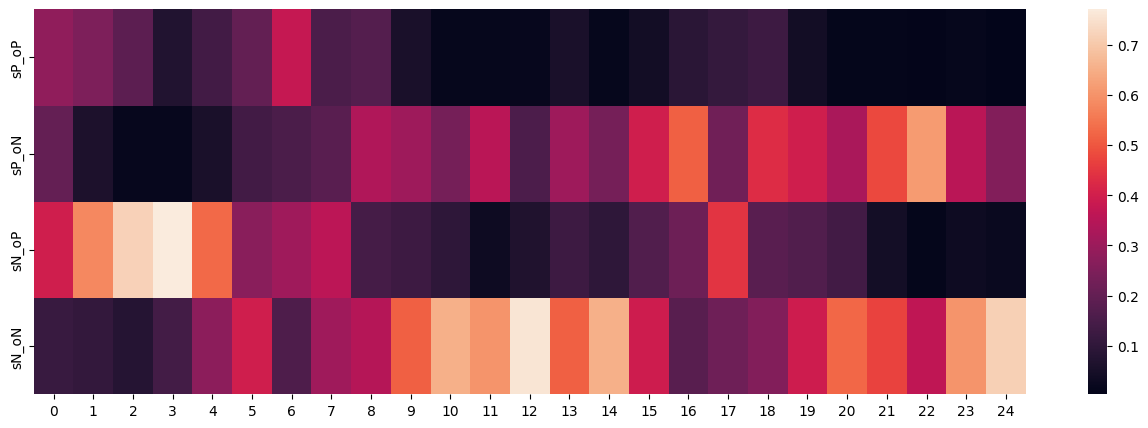

In [17]:
import seaborn as sns

labels = {
    0: "s_pos_o_zer",
    1: "s_neg_o_zer",
    2: "s_zer_o_pos",
    3: "s_zer_o_neg",
    4: "s_zer_o_zer",
}

n_block = 0
n_subject = 0

plt.figure(figsize=(16, 5))
sns.heatmap(samples["beliefs"][0][0][n_block, n_subject].T)
plt.yticks([0.5, 1.5, 2.5, 3.5], labels=agency_names)

exp_condition = samples["states"][-1][0][0]

print(labels[exp_condition[n_block, n_subject].item()])

In [18]:
exp_condition = samples["states"][-1][0][0]
last_beliefs_about_condition = samples["beliefs"][0][..., -1, :]

self_rating = (
    last_beliefs_about_condition[0, ..., 0]
    + last_beliefs_about_condition[0, ..., 1]
    - last_beliefs_about_condition[0, ..., 2]
    - last_beliefs_about_condition[0, ..., 3]
)

other_rating = (
    last_beliefs_about_condition[0, ..., 0]
    + last_beliefs_about_condition[0, ..., 2]
    - last_beliefs_about_condition[0, ..., 1]
    - last_beliefs_about_condition[0, ..., 3]
)

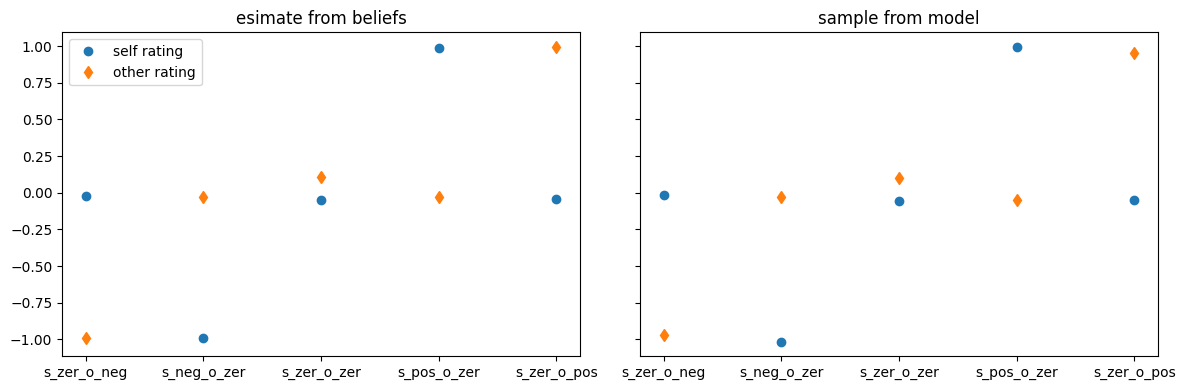

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

smpl_other_rating = samples["aux_other"][0, ..., -1]
smpl_self_rating = samples["aux_self"][0, ..., -1]

x = []
y1 = []
y2 = []
smpl_y1 = []
smpl_y2 = []
for i in [3, 1, 4, 0, 2]:
    loc = exp_condition == i
    x.append(labels[i])
    y1.append(self_rating[loc].mean())
    y2.append(other_rating[loc].mean())

    smpl_y1.append(smpl_self_rating[loc].mean())
    smpl_y2.append(smpl_other_rating[loc].mean())

axes[0].plot(x, y1, "o", label="self rating")
axes[0].plot(x, y2, "d", label="other rating")

axes[1].plot(x, smpl_y1, "o", label="self rating")
axes[1].plot(x, smpl_y2, "d", label="other rating")

axes[0].set_title("esimate from beliefs")
axes[1].set_title("sample from model")

axes[0].legend()
fig.tight_layout()

### Parameter recovery with simulated behaviour

Here we will demonstrate that the model parameters are recoverable, 
if one simulates the behavior using the paramatric generative model 
of the active inference agents, and then inverts the model using the 
simulated responses. Bellow we illustrate that all of the 8 parameters 
are well recoverable, as the estimated means fall along the axis that 
follows true parameter values. 

{'seed': 101, 'enumerate': False, 'iter_steps': 1000, 'optim': None, 'optim_kwargs': {'learning_rate': 0.001}, 'elbo_kwargs': {'num_particles': 10, 'max_plate_nesting': 1}, 'svi_kwargs': {'progress_bar': True, 'stable_update': True}, 'sample_kwargs': {'num_samples': 100}}


  0%|          | 0/1000 [00:00<?, ?it/s]2024-08-26 23:41:43.101326: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 21m35.271979s

********************************
[Compiling module jit_body_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
100%|██████████| 1000/1000 [41:09<00:00,  2.47s/it, init loss: 46022.7812, avg. loss [951-1000]: 16918.6562]


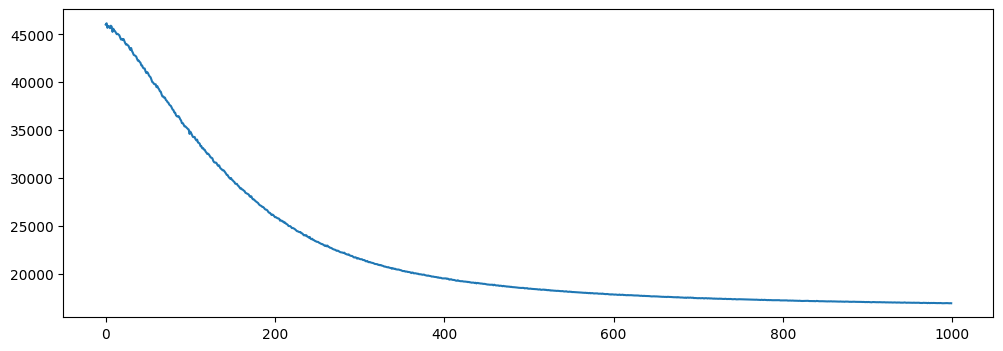

In [20]:
measurments = {
    "outcomes": [outcomes[0] for outcomes in samples["outcomes"]],
    "multiactions": samples["multiactions"][0],
    "multiaction_cat": samples["multiaction_cat"][0],
    "auxiliary_actions": [
        samples["aux_self"][0],
        samples["aux_other"][0],
    ],
}

model = NumpyroModel(prior, transform, likelihood, opts=opts_model)
posterior = NumpyroGuide(NormalPosterior(num_params, num_agents, backend="numpyro"))

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 1000, "seed": 101}
print(opts_svi)

svi_samples, svi, results = run_svi(model, posterior, measurments, opts=opts_svi)
plt.figure(figsize=(12, 4))
plt.plot(results.losses)

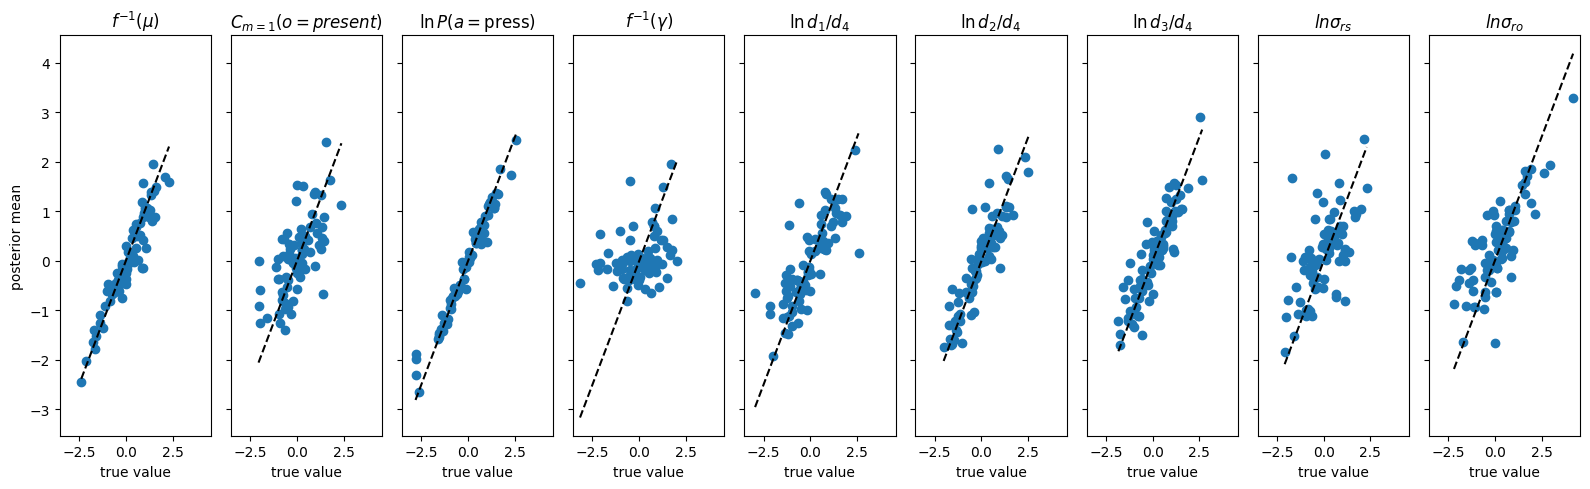

In [21]:
param_label = [
    r"$f^{-1}(\mu)$",
    r"$C_{m=1}(o=present)$",
    r"$\ln P(a=\text{press})$",
    r"$f^{-1}(\gamma)$",
    r"$\ln d_1/d_4$",
    r"$\ln d_2/d_4$",
    r"$\ln d_3/d_4$",
    r"$ln \sigma_{rs}$",
    r"$ln \sigma_{ro}$",
]
z = samples["z"][0]
fig, axes = plt.subplots(1, z.shape[-1], figsize=(16, 5), sharex=True, sharey=True)

for i in range(z.shape[-1]):
    axes[i].scatter(z[:, i], svi_samples["z"].mean(0)[:, i], label=i)
    axes[i].plot((z[:, i].min(), z[:, i].max()), (z[:, i].min(), z[:, i].max()), "k--")
    axes[i].set_xlabel("true value")
    axes[i].set_title(param_label[i])

axes[0].set_ylabel("posterior mean")
fig.tight_layout()

## Fitting behavioural data

In [22]:
import pandas as pd

exp_data = pd.read_csv("behavioural_data_agency.csv")

outcomes = [[], [], []]
multiactions = []
ratings = [[], []]
group = []
for pid in exp_data.PID.unique():
    df = exp_data.loc[exp_data.PID == pid].pivot(
        index=["block_num"],
        columns=["timesteps"],
        values=[
            "outcome",
            "action_self",
            "action_other",
            "rating_self",
            "rating_other",
        ],
    )
    group.append(exp_data.loc[exp_data.PID == pid].depgroup.unique().item())
    outcomes[0].append(jnp.array(df.outcome.values))
    outcomes[1].append(jnp.array(df.action_self.values))
    outcomes[2].append(jnp.array(df.action_other.values))

    ratings[0].append(jnp.array(df.rating_self.values))

    ratings[1].append(jnp.array(df.rating_other.values))

    for o in outcomes:
        if jnp.any(jnp.isnan(o[-1])):
            print(pid)

    multiactions.append(outcomes[1][-1])


# set "nondep" as 0, and "dep" as 1
dep_group = jnp.array([False if g == "nondep" else True for g in group])

outcomes = [jnp.pad(jnp.stack(o, 1), [(0, 0), (0, 0), (1, 0)]) for o in outcomes]
multiactions = jnp.pad(
    jnp.stack(multiactions, 1)[..., None], [(0, 0), (0, 0), (0, 0), (1, 1)]
)

ratings = [jnp.stack(r, 1) / 100 for r in ratings]
exp_measurments = {
    "outcomes": outcomes,
    "multiactions": multiactions,
    "auxiliary_actions": ratings,
}

opts_task = {
    "num_blocks": multiactions.shape[0],
    "num_trials": multiactions.shape[-2],
    "num_agents": multiactions.shape[1],
    "record_agent": False,
}

opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

In [23]:
def plot_results(samples):
    param_label = [
        r"$f^{-1}(\mu)$",
        r"$C_{m=1}(o=present)$",
        r"$\ln P(a=\text{press})$",
        r"$f^{-1}(\gamma)$",
        r"$\ln d_1/d_4$",
        r"$\ln d_2/d_4$",
        r"$\ln d_3/d_4$",
        r"$ln \sigma_{rs}$",
        r"$ln \sigma_{ro}$",
    ]

    fig, axes = plt.subplots(1, num_params, figsize=(16, 5), sharex=True, sharey=True)
    grp = jnp.array([0 if g == "nondep" else 1 for g in group])
    dep = grp == 1
    for i in range(num_params):
        sns.stripplot(samples["z"].mean(0)[~dep, i], ax=axes[i], label="nondep")
        sns.stripplot(samples["z"].mean(0)[dep, i], ax=axes[i], label="dep")
        axes[i].set_title(param_label[i])

    axes[0].legend(title="group")
    axes[0].set_ylabel("value")
    fig.tight_layout()


def plot_results2(samples):
    param_label = [
        r"$\mu$",
        r"$C_{m=1}(o=present)$",
        r"$P(a=\text{press})$",
        r"$\gamma$",
        r"$d_1/d_4$",
        r"$d_2/d_4$",
        r"$d_3/d_4$",
        r"$\sigma_{rs}$",
        r"$\sigma_{ro}$",
    ]

    D0 = jnp.mean(samples["D"][0][..., :-1] / samples["D"][0][..., -1:], 0)

    fig, axes = plt.subplots(2, (num_params + 1) // 2, figsize=(16, 5), sharex=True)
    axes = axes.flatten()
    grp = jnp.array([0 if g == "nondep" else 1 for g in group])
    dep = grp == 1
    for i in range(num_params):
        if param_label[i] == r"$\mu$":
            sns.stripplot(
                samples["expected_outcome"].mean(0)[~dep], ax=axes[i], label="nondep"
            )
            sns.stripplot(
                samples["expected_outcome"].mean(0)[dep], ax=axes[i], label="dep"
            )
        elif param_label[i] == r"$C_{m=1}(o=present)$":
            sns.stripplot(
                samples["outcome_pref"].mean(0)[~dep], ax=axes[i], label="nondep"
            )
            sns.stripplot(samples["outcome_pref"].mean(0)[dep], ax=axes[i], label="dep")

        elif param_label[i] == r"$P(a=\text{press})$":
            sns.stripplot(samples["E"].mean(0)[~dep, 1], ax=axes[i], label="nondep")
            sns.stripplot(samples["E"].mean(0)[dep, 1], ax=axes[i], label="dep")
        elif param_label[i] == r"$\gamma$":
            sns.stripplot(samples["gamma"].mean(0)[~dep], ax=axes[i], label="nondep")
            sns.stripplot(samples["gamma"].mean(0)[dep], ax=axes[i], label="dep")
        elif "d_4" in param_label[i]:
            sns.stripplot(D0[~dep, i - 4], ax=axes[i], label="nondep")
            sns.stripplot(D0[dep, i - 4], ax=axes[i], label="dep")
        elif param_label[i] == r"$\sigma_{rs}$":
            sns.stripplot(
                samples["scale_self"].mean(0)[0, ~dep], ax=axes[i], label="nondep"
            )
            sns.stripplot(
                samples["scale_self"].mean(0)[0, dep], ax=axes[i], label="dep"
            )
        elif param_label[i] == r"$\sigma_{ro}$":
            sns.stripplot(
                samples["scale_other"].mean(0)[0, ~dep], ax=axes[i], label="nondep"
            )
            sns.stripplot(
                samples["scale_other"].mean(0)[0, dep], ax=axes[i], label="dep"
            )

        axes[i].set_title(param_label[i])

    axes[0].legend(title="group")
    axes[0].set_ylabel("value")
    fig.tight_layout()

First we will fit the data using a simple flat prior over model parameters, where each uncostrained values of each parameter (before transform) are sampled from a standard noraml distribution. 

In [24]:
# prior = Normal(num_params, num_agents, backend="numpyro")
# model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

# posterior = NumpyroGuide(NormalPosterior(num_params, num_agents, backend="numpyro"))

# # perform inference using stochastic variational inference
# opts_svi = default_dict_numpyro_svi | {"iter_steps": 5000, "seed": 1123567}
# svi_samples1, svi1, results1 = run_svi(model, posterior, exp_measurments, opts=opts_svi)

# plt.figure(figsize=(12, 4))
# plt.plot(results1.losses)

In [25]:
# plot_results(svi_samples1)

In [26]:
# # we can also plot parameters in constrained space
# plot_results2(svi_samples1)

In [27]:
# # simulating behaviour from posterior samples

# opts_task = {
#     "task": agency_task,
#     "num_blocks": num_blocks,
#     "num_trials": num_timesteps,
#     "num_agents": num_agents,
#     "record_agent": True,  # setting this to true creates an 'init_agent' and 'agent_sequence' variable in samples (posterior or prior samples)
# }
# opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

# prior = Normal(num_params, num_agents, backend="numpyro")
# model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

# pred = Predictive(model, guide=posterior, params=results1.params, num_samples=1)
# key, _key = jr.split(key)
# post_pred_samples = pred(_key)

In [28]:
# post_pred_samples.keys()

As a second example we will fit the data using the NormalGamma prior over unconstrained parameter values, where one infers prior uncertainty on a group level for each parameter. 

In [29]:
# prior = NormalGamma(num_params, num_agents, backend="numpyro")
# model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

# posterior = NumpyroGuide(
#     NormalGammaPosterior(num_params, num_agents, backend="numpyro")
# )

# # perform inference using stochastic variational inference
# opts_svi = default_dict_numpyro_svi | {"iter_steps": 5000, "seed": 197823476}
# svi_samples2, svi2, results2 = run_svi(model, posterior, exp_measurments, opts=opts_svi)

# plt.figure(figsize=(12, 4))
# plt.plot(results2.losses)

In [30]:
# plot_results(svi_samples2)

As a final exmaple we will fit the data using the RegularisedHorseshoe prior over unconstrained parameter values. This prior puts a lots of a priory wait on group mean, as an only relevant parameter, hence it has a strong pulling effect between participants, which can help to estimate corretly group level mean, when the experimental data do not contain sufficient information about specific parameter value on a single subject level.

  0%|          | 0/5000 [00:00<?, ?it/s]2024-08-27 00:07:16.029887: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m52.72792s

********************************
[Compiling module jit_body_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
100%|██████████| 5000/5000 [1:40:44<00:00,  1.21s/it, init loss: 45071.3750, avg. loss [4751-5000]: 18790.0273]


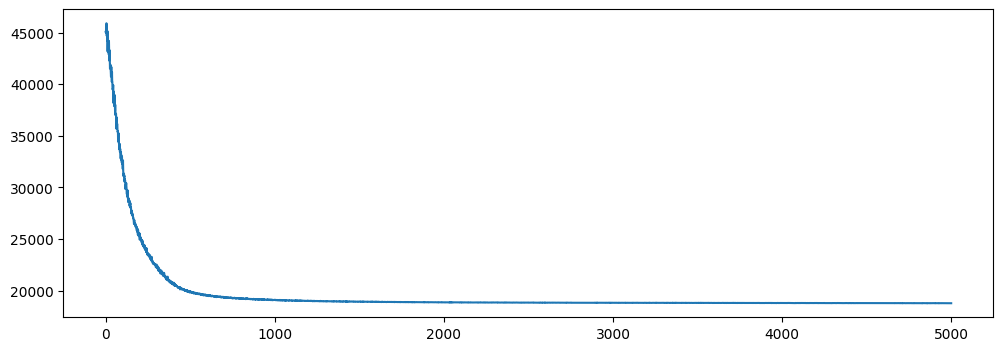

In [31]:
prior = RegularisedHorseshoe(num_params, num_agents, backend="numpyro")
model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

posterior = NumpyroGuide(
    RegularisedHorseshoePosterior(num_params, num_agents, backend="numpyro")
)

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 5000, "seed": 623342}
svi_samples3, svi3, results3 = run_svi(model, posterior, exp_measurments, opts=opts_svi)

plt.figure(figsize=(12, 4))
plt.plot(results3.losses)

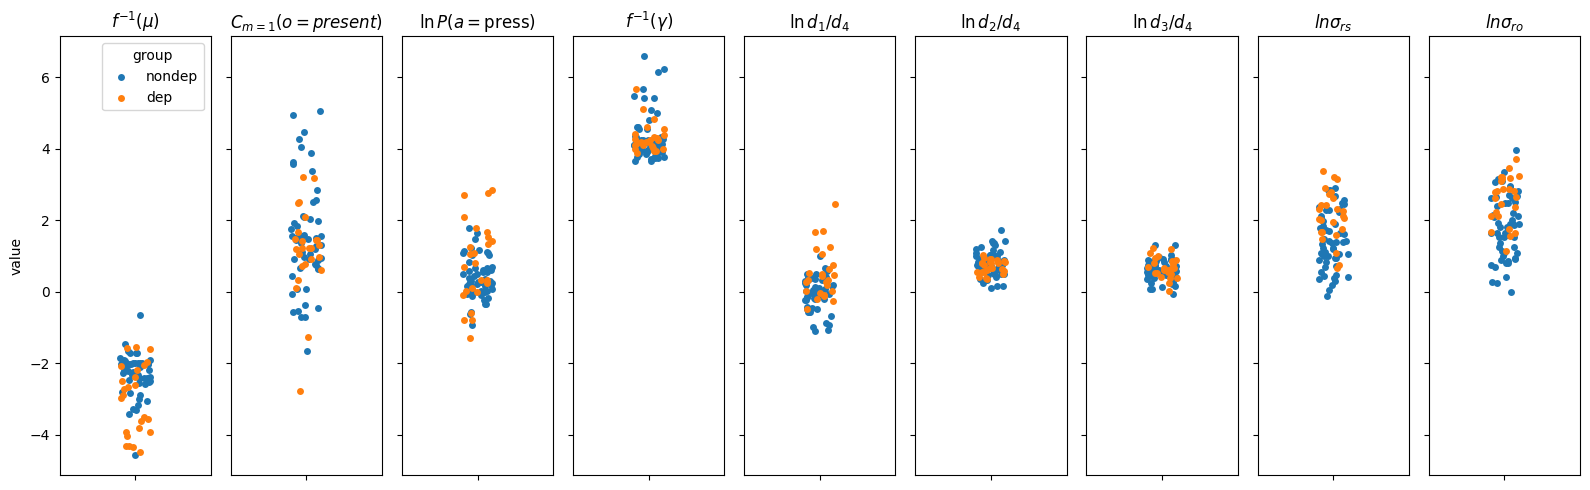

In [32]:
plot_results(svi_samples3)

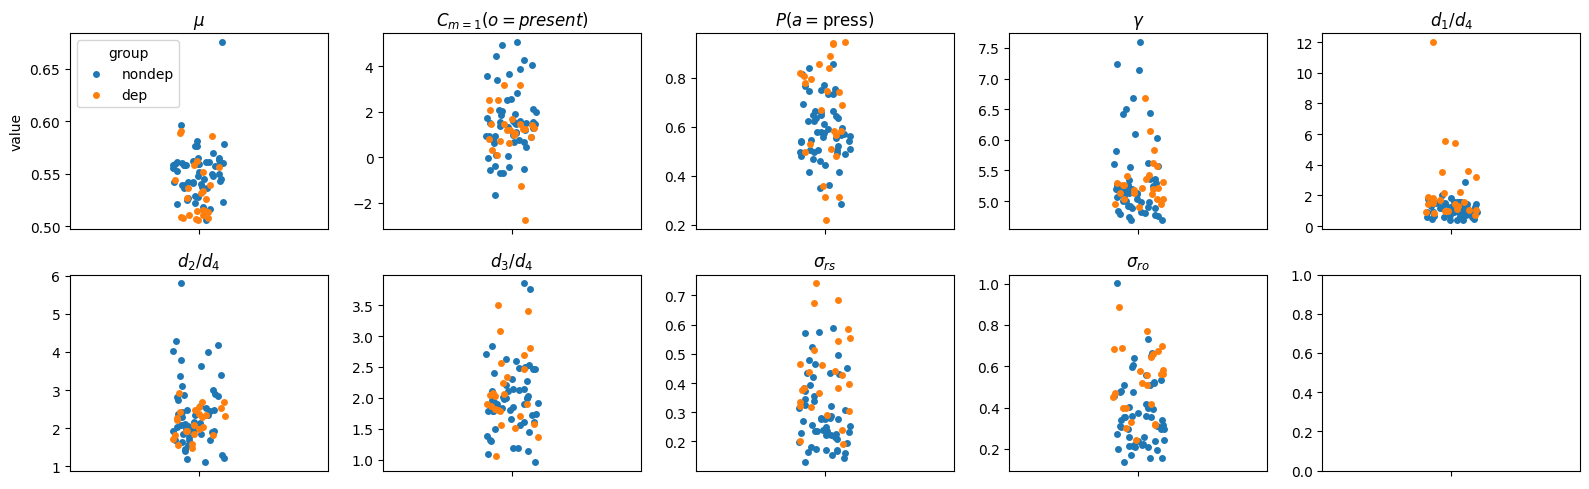

In [33]:
# plot_results2(svi_samples3)

In [34]:
# simulating behaviour from posterior samples

opts_task = {
    "task": agency_task,
    "num_blocks": num_blocks,
    "num_trials": num_timesteps,
    "num_agents": num_agents,
    "record_agent": True,  # setting this to true creates an 'init_agent' and 'agent_sequence' variable in samples (posterior or prior samples)
}
opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

prior = RegularisedHorseshoe(num_params, num_agents, backend="numpyro")
model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

pred = Predictive(model, guide=posterior, params=results3.params, num_samples=1)
key, _key = jr.split(key)
post_pred_samples = pred(_key)

2024-08-27 01:45:10.147390: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-08-27 01:50:44.517765: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 7m34.380482s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [52]:
post_pred_samples.keys()

# print(post_pred_samples["D"][0])
print(post_pred_samples["D"])

[Array([[[0.1258945 , 0.3311788 , 0.32982567, 0.21310103],
        [0.05433732, 0.40759522, 0.36066484, 0.1774026 ],
        [0.14319777, 0.330041  , 0.42393118, 0.10283009],
        [0.05106897, 0.42679024, 0.38017088, 0.14196993],
        [0.10078708, 0.3672779 , 0.3323235 , 0.19961147],
        [0.15480773, 0.39235273, 0.30951023, 0.14332929],
        [0.11732867, 0.337792  , 0.3519345 , 0.19294484],
        [0.26453844, 0.36195305, 0.27491665, 0.0985919 ],
        [0.08932306, 0.47801396, 0.20599931, 0.22666359],
        [0.07452673, 0.5739723 , 0.23690613, 0.11459489],
        [0.22303909, 0.28867504, 0.25596163, 0.23232418],
        [0.10139212, 0.42217258, 0.35671756, 0.1197177 ],
        [0.16441336, 0.25547543, 0.43247023, 0.14764096],
        [0.21630014, 0.3306945 , 0.29412872, 0.15887664],
        [0.2655921 , 0.24369231, 0.27517426, 0.21554136],
        [0.18319061, 0.42906672, 0.3015258 , 0.08621685],
        [0.17093766, 0.2441892 , 0.41811568, 0.1667575 ],
        [0.24

# Fitting Depressed and Non-Depressed

  0%|          | 0/5000 [00:00<?, ?it/s]2024-08-27 01:56:54.675121: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m43.847956s

********************************
[Compiling module jit_body_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
100%|██████████| 5000/5000 [37:16<00:00,  2.24it/s, init loss: 17267.5137, avg. loss [4751-5000]: 5517.8145]


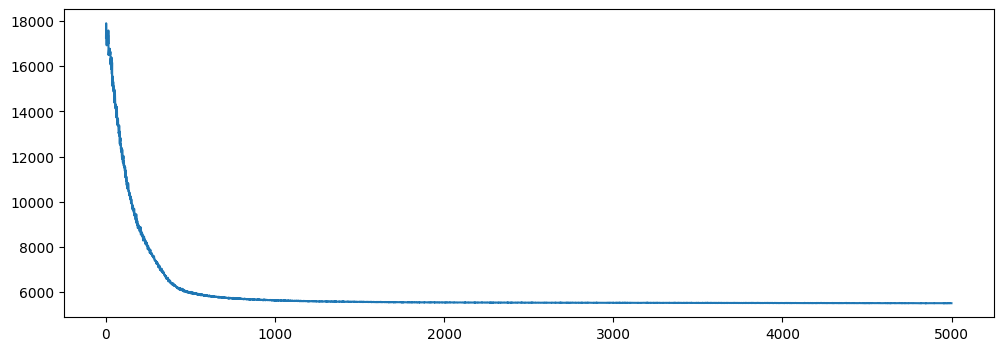

In [36]:
# fit depressed
dep_data = jtu.tree_map(lambda x: x[:, dep_group], exp_measurments)
num_dep_agents = dep_group.sum().item()
opts_task["num_agents"] = num_dep_agents

opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

prior = RegularisedHorseshoe(num_params, num_dep_agents, backend="numpyro")
model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

posterior = NumpyroGuide(
    RegularisedHorseshoePosterior(num_params, num_dep_agents, backend="numpyro")
)

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 5000, "seed": 6242}
svi_samples_dep, svi_dep, results_dep = run_svi(
    model, posterior, dep_data, opts=opts_svi
)

plt.figure(figsize=(12, 4))
plt.plot(results_dep.losses)

In [55]:
# simulating behaviour from posterior samples

opts_task = {
    "task": agency_task,
    "num_blocks": num_blocks,
    "num_trials": num_timesteps,
    "num_agents": num_dep_agents,
    "record_agent": True,  # setting this to true creates an 'init_agent' and 'agent_sequence' variable in samples (posterior or prior samples)
}
opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

prior = RegularisedHorseshoe(num_params, num_dep_agents, backend="numpyro")
model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

pred = Predictive(model, guide=posterior, params=results_dep.params, num_samples=1)
key, _key = jr.split(key)
post_pred_samples = pred(_key)

ValueError: Incompatible shapes for broadcasting: shapes=[(55,), (25,)]

  0%|          | 0/5000 [00:00<?, ?it/s]2024-08-27 02:32:42.434851: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_body_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-08-27 02:35:26.061230: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m43.636417s

********************************
[Compiling module jit_body_fn] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
100%|██████████| 5000/5000 [1:10:51<00:00,  1.18it/s, init loss: 27894.6777, avg. loss [4751-5000]: 13282.0068]


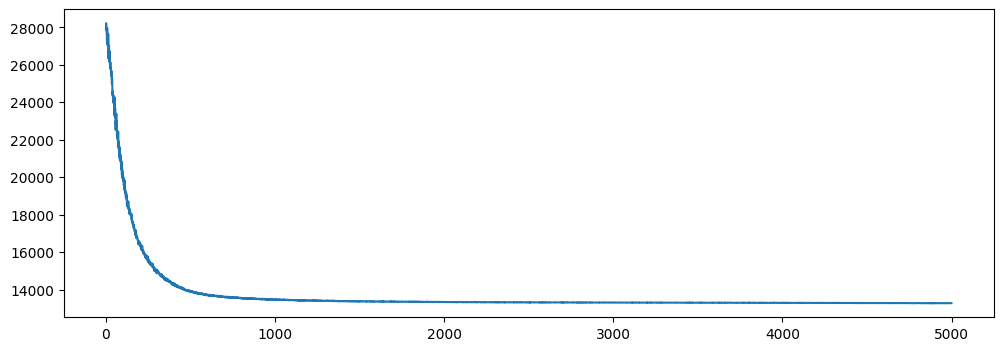

In [37]:
# fit non-depressed
dep_data = jtu.tree_map(lambda x: x[:, ~dep_group], exp_measurments)
num_nondep_agents = num_agents - dep_group.sum().item()
opts_task["num_agents"] = num_nondep_agents

opts_model = {"prior": {}, "transform": {}, "likelihood": opts_task}

prior = RegularisedHorseshoe(num_params, num_nondep_agents, backend="numpyro")
model = NumpyroModel(prior, transform, likelihood, opts=opts_model)

posterior = NumpyroGuide(
    RegularisedHorseshoePosterior(num_params, num_nondep_agents, backend="numpyro")
)

# perform inference using stochastic variational inference
opts_svi = default_dict_numpyro_svi | {"iter_steps": 5000, "seed": 3342}
svi_samples_nondep, svi_nondep, results_nondep = run_svi(
    model, posterior, dep_data, opts=opts_svi
)

plt.figure(figsize=(12, 4))
plt.plot(results_nondep.losses)

In [38]:
# group mean and uncertainty in unconstrained parameter space
print("dep: ", svi_samples_dep["mu"].mean(0))
print(
    "dep: ",
    svi_samples_dep["mu"].var(0) + jnp.mean(svi_samples_dep["sigma"] ** 2, axis=0),
)

print("non-dep: ", svi_samples_nondep["mu"].mean(0))
print(
    "non-dep: ",
    svi_samples_nondep["mu"].var(0)
    + jnp.mean(svi_samples_nondep["sigma"] ** 2, axis=0),
)

dep:  [-2.2725022   0.5505774   0.78528523  2.5143576   0.67601675  0.70476246
  0.7114834   1.5129124   1.6271232 ]
dep:  [1.7114009  1.7671428  1.5666685  1.7316408  0.7925254  0.2574447
 0.58405894 1.5494527  1.6679119 ]
non-dep:  [-1.9054507   1.6885334   0.3818508   3.498174   -0.07532935  0.7657553
  0.5711583   1.1928809   1.4951161 ]
non-dep:  [0.5357691  3.299775   0.3308947  3.1904366  0.16978614 0.19218709
 0.1568969  0.8042071  1.0650944 ]


In [39]:
# printing out parameters
### Final Vectors @ Jax [SPOP, SPON, SNOP, SNON]
### Depressed Group: [0.278, 0.290, 0.290, 0.143]
### Non-Depressed Group: [0.157, 0.368, 0.305, 0.170]
def print_parameter_stats(samples, group_name):
    mu = samples["mu"].mean(0)
    sigma = jnp.sqrt(samples["mu"].var(0) + jnp.mean(samples["sigma"] ** 2, axis=0))
    param_labels = [
        r"$f^{-1}(\mu)$",
        r"$C_{m=1}(o=present)$",
        r"$\ln P(a=\text{press})$",
        r"$f^{-1}(\gamma)$",
        r"$\ln d_1/d_4$",
        r"$\ln d_2/d_4$",
        r"$\ln d_3/d_4$",
        r"$ln \sigma_{rs}$",
        r"$ln \sigma_{ro}$",
    ]

    print(f"Parameter statistics for {group_name} group:")
    for label, mean, sd in zip(param_labels, mu, sigma):
        print(f"{label}: Mean = {mean:.2f}, SD = {sd:.2f}")


print_parameter_stats(svi_samples_dep, "Depressed")
print_parameter_stats(svi_samples_nondep, "Non-Depressed")

Parameter statistics for Depressed group:
$f^{-1}(\mu)$: Mean = -2.27, SD = 1.31
$C_{m=1}(o=present)$: Mean = 0.55, SD = 1.33
$\ln P(a=\text{press})$: Mean = 0.79, SD = 1.25
$f^{-1}(\gamma)$: Mean = 2.51, SD = 1.32
$\ln d_1/d_4$: Mean = 0.68, SD = 0.89
$\ln d_2/d_4$: Mean = 0.70, SD = 0.51
$\ln d_3/d_4$: Mean = 0.71, SD = 0.76
$ln \sigma_{rs}$: Mean = 1.51, SD = 1.24
$ln \sigma_{ro}$: Mean = 1.63, SD = 1.29
Parameter statistics for Non-Depressed group:
$f^{-1}(\mu)$: Mean = -1.91, SD = 0.73
$C_{m=1}(o=present)$: Mean = 1.69, SD = 1.82
$\ln P(a=\text{press})$: Mean = 0.38, SD = 0.58
$f^{-1}(\gamma)$: Mean = 3.50, SD = 1.79
$\ln d_1/d_4$: Mean = -0.08, SD = 0.41
$\ln d_2/d_4$: Mean = 0.77, SD = 0.44
$\ln d_3/d_4$: Mean = 0.57, SD = 0.40
$ln \sigma_{rs}$: Mean = 1.19, SD = 0.90
$ln \sigma_{ro}$: Mean = 1.50, SD = 1.03


/Users/riddhi/Library/CloudStorage/OneDrive-Nexus365/Oxford/Research Projects/Ox_AgencyParadox/1_Data&Analysis/jax_aifagent/pybefit/.venv/lib/python3.12/site-packages/matplotlib/axes/_axes.py:3741: RuntimeWarning: divide by zero encountered in negative
  if np.any(np.less(err, -err, out=res, where=(err == err))):
/Users/riddhi/Library/CloudStorage/OneDrive-Nexus365/Oxford/Research Projects/Ox_AgencyParadox/1_Data&Analysis/jax_aifagent/pybefit/.venv/lib/python3.12/site-packages/matplotlib/axes/_axes.py:3741: RuntimeWarning: divide by zero encountered in equal
  if np.any(np.less(err, -err, out=res, where=(err == err))):
/Users/riddhi/Library/CloudStorage/OneDrive-Nexus365/Oxford/Research Projects/Ox_AgencyParadox/1_Data&Analysis/jax_aifagent/pybefit/.venv/lib/python3.12/site-packages/matplotlib/axes/_axes.py:3741: RuntimeWarning: divide by zero encountered in less
  if np.any(np.less(err, -err, out=res, where=(err == err))):
/Users/riddhi/Library/CloudStorage/OneDrive-Nexus365/Oxford/Re

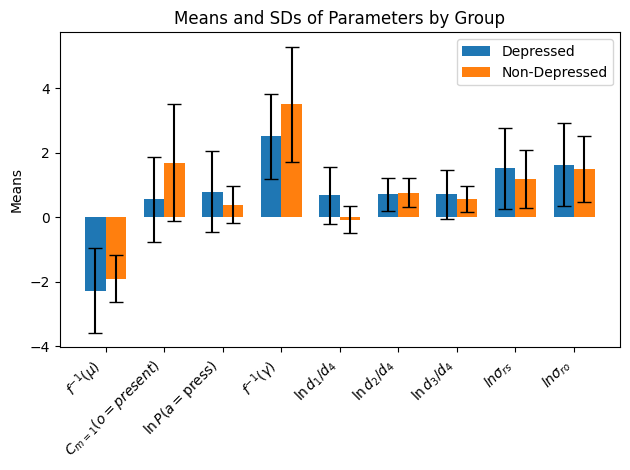

In [40]:
def plot_group_parameters(samples_dep, samples_nondep, param_labels):
    mu_dep = samples_dep["mu"].mean(0)
    sigma_dep = jnp.sqrt(
        samples_dep["mu"].var(0) + jnp.mean(samples_dep["sigma"] ** 2, axis=0)
    )

    mu_nondep = samples_nondep["mu"].mean(0)
    sigma_nondep = jnp.sqrt(
        samples_nondep["mu"].var(0) + jnp.mean(samples_nondep["sigma"] ** 2, axis=0)
    )

    x = jnp.arange(len(param_labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(
        x - width / 2, mu_dep, width, yerr=sigma_dep, label="Depressed", capsize=5
    )
    rects2 = ax.bar(
        x + width / 2,
        mu_nondep,
        width,
        yerr=sigma_nondep,
        label="Non-Depressed",
        capsize=5,
    )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel("Means")
    ax.set_title("Means and SDs of Parameters by Group")
    ax.set_xticks(x)
    ax.set_xticklabels(param_labels, rotation=45, ha="right")
    ax.legend()

    fig.tight_layout()
    plt.show()


param_labels = [
    r"$f^{-1}(\mu)$",
    r"$C_{m=1}(o=present)$",
    r"$\ln P(a=\text{press})$",
    r"$f^{-1}(\gamma)$",
    r"$\ln d_1/d_4$",
    r"$\ln d_2/d_4$",
    r"$\ln d_3/d_4$",
    r"$ln \sigma_{rs}$",
    r"$ln \sigma_{ro}$",
]

plot_group_parameters(svi_samples_dep, svi_samples_nondep, param_labels)